In [1]:
import pandas as pd
import numpy as np

import utils.print as print_f

from utils.coco_eval import get_eval_params_dict
from utils.engine import xami_train_one_epoch, xami_evaluate, get_iou_types
from utils.plot import plot_losses, plot_train_val_ap_ars, get_ap_ar_for_train_val
from utils.save import get_data_from_metric_logger
from utils.coco_utils import get_cocos

from models.setup import ModelSetup
from models.build import create_model_from_setup
from models.train import TrainingInfo
from utils.save import check_best, end_train
from data.load import get_datasets, get_dataloaders

from IPython.display import clear_output
from utils.eval import get_ar_ap
from utils.train import get_optimiser, get_lr_scheduler, print_params_setup
from utils.init import reproducibility, clean_memory_get_device
from data.constants import DEFAULT_REFLACX_LABEL_COLS, XAMI_MIMIC_PATH
from  datetime import datetime
import torch.optim as optim

## Suppress the assignement warning from pandas.r
pd.options.mode.chained_assignment = None  # default='warn'

## Supress user warning
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

%matplotlib inline

In [2]:
### [TODO] ###

# [ ] -


In [3]:
device = clean_memory_get_device()
reproducibility()


This notebook will running on device: [CUDA]


In [4]:
use_iobb = True
io_type_str = "IoBB" if use_iobb else "IoU"
labels_cols = DEFAULT_REFLACX_LABEL_COLS
iou_thrs = np.array([0.5])


# patience=10, but start with 1e-2.
all_model_setups = [
    # ModelSetup(
    #     name="with_clinical_add_res",
    #     use_clinical=True,
    #     use_custom_model=True,
    #     use_early_stop_model=True,
    #     best_ar_val_model_path=None,
    #     best_ap_val_model_path=None,
    #     final_model_path=None,
    #     backbone="mobilenet_v3",
    #     optimiser="sgd",
    #     lr=1e-2,
    #     weight_decay=0.001,
    #     pretrained=True,
    #     record_training_performance=True,
    #     dataset_mode="unified",
    #     image_size=256,
    #     backbone_out_channels=16,
    #     batch_size=4,
    #     warmup_epochs=0,
    #     lr_scheduler="ReduceLROnPlateau",
    #     reduceLROnPlateau_factor=0.1,
    #     reduceLROnPlateau_patience=10,
    #     multiStepLR_milestones=[30, 50, 70, 90],
    #     multiStepLR_gamma=0.1,
    #     representation_size=32,
    #     mask_hidden_layers=256,
    #     using_fpn=False,
    #     use_mask=False,
    #     clinical_expand_dropout_rate=0,
    #     clinical_conv_dropout_rate=0,
    #     clinical_input_channels=32,
    #     clinical_num_len=9,
    #     clinical_conv_channels=32,
    #     fuse_conv_channels=32,
    #     fuse_dropout_rate=0,
    #     box_head_dropout_rate=0,
    #     fuse_depth=4,
    #     fusion_strategy="add",
    #     fusion_residule=True,
    # ),
    ModelSetup(
        name="CXR",
        use_clinical=False,
        use_custom_model=True,
        use_early_stop_model=True,
        best_ar_val_model_path=None,
        best_ap_val_model_path=None,
        final_model_path=None,
        backbone="resnet50",
        using_fpn=True,
        optimiser="sgd",
        lr=1e-3,
        # lr=1e-4,
        # weight_decay=0.001,
        weight_decay=0,
        pretrained=True,
        record_training_performance=True,
        dataset_mode="unified",
        image_size=256,
        backbone_out_channels=16,
        batch_size=4,
        warmup_epochs=0,
        # lr_scheduler="ReduceLROnPlateau",
        lr_scheduler=None,
        reduceLROnPlateau_factor=0.1,
        reduceLROnPlateau_patience=10,
        reduceLROnPlateau_full_stop=False,
        multiStepLR_milestones=[100],
        multiStepLR_gamma=0.1,
        mask_hidden_layers=256,
        use_mask=False,
        clinical_expand_dropout_rate=0,
        clinical_conv_dropout_rate=0,
        clinical_num_len=9,
        fuse_conv_channels=32,
        fuse_dropout_rate=0,
        box_head_dropout_rate=0,
        fuse_depth=4,
        fusion_strategy="add",
        fusion_residule=False,
        clinical_input_channels=64,
        representation_size=32, # 32
        clinical_conv_channels=256,
    ),
    ModelSetup(
        name="CXR_Clinical",
        use_clinical=True,
        use_custom_model=True,
        use_early_stop_model=True,
        best_ar_val_model_path=None,
        best_ap_val_model_path=None,
        final_model_path=None,
        backbone="resnet50",
        using_fpn=True,
        optimiser="sgd",
        lr=1e-3,
        # lr=1e-4,
        # weight_decay=0.001,
        weight_decay=0,
        pretrained=True,
        record_training_performance=True,
        dataset_mode="unified",
        image_size=256,
        backbone_out_channels=16,
        batch_size=4,
        warmup_epochs=0,
        # lr_scheduler="ReduceLROnPlateau",
        lr_scheduler=None,
        reduceLROnPlateau_factor=0.1,
        reduceLROnPlateau_patience=10,
        reduceLROnPlateau_full_stop=False,
        multiStepLR_milestones=[100],
        multiStepLR_gamma=0.1,
        mask_hidden_layers=256,
        use_mask=False,
        clinical_expand_dropout_rate=0,
        clinical_conv_dropout_rate=0,
        clinical_num_len=9,
        fuse_conv_channels=32,
        fuse_dropout_rate=0,
        box_head_dropout_rate=0,
        fuse_depth=4,
        fusion_strategy="add",
        fusion_residule=False,
        clinical_input_channels=64,
        representation_size=32, # 32
        clinical_conv_channels=256,
    ),

    # ModelSetup(
    #     name="CXR+Clinical",
    #     use_clinical=True,
    #     use_custom_model=True,
    #     use_early_stop_model=True,
    #     best_ar_val_model_path=None,
    #     best_ap_val_model_path=None,
    #     final_model_path=None,
    #     backbone="mobilenet_v3",
    #     optimiser="sgd",
    #     lr=1e-3,
    #     # lr=1e-4,
    #     # weight_decay=0.001,
    #     weight_decay=0,
    #     pretrained=True,
    #     record_training_performance=True,
    #     dataset_mode="unified",
    #     image_size=256,
    #     backbone_out_channels=16,
    #     batch_size=4,
    #     warmup_epochs=0,
    #     lr_scheduler="ReduceLROnPlateau",
    #     # lr_scheduler=None,
    #     reduceLROnPlateau_factor=0.1,
    #     reduceLROnPlateau_patience=10,
    #     reduceLROnPlateau_full_stop=False,
    #     multiStepLR_milestones=[30, 50, 70, 90],
    #     multiStepLR_gamma=0.1,
    #     representation_size=32,
    #     mask_hidden_layers=256,
    #     using_fpn=False,
    #     use_mask=False,
    #     clinical_expand_dropout_rate=0,
    #     clinical_conv_dropout_rate=0,
    #     clinical_input_channels=32,
    #     clinical_num_len=9,
    #     clinical_conv_channels=32,
    #     fuse_conv_channels=32,
    #     fuse_dropout_rate=0,
    #     box_head_dropout_rate=0,
    #     fuse_depth=4,
    #     fusion_strategy="add",
    #     fusion_residule=False,
    # ),
    # ModelSetup(
    #     name="CXR",
    #     use_clinical=False,
    #     use_custom_model=True,
    #     use_early_stop_model=True,
    #     best_ar_val_model_path=None,
    #     best_ap_val_model_path=None,
    #     final_model_path=None,
    #     backbone="mobilenet_v3",
    #     optimiser="sgd",
    #     lr=1e-3,
    #     # lr=1e-4,
    #     # weight_decay=0.001,
    #     weight_decay=0,
    #     pretrained=True,
    #     record_training_performance=True,
    #     dataset_mode="unified",
    #     image_size=256,
    #     backbone_out_channels=16,
    #     batch_size=4,
    #     warmup_epochs=0,
    #     lr_scheduler="ReduceLROnPlateau",
    #     # lr_scheduler=None,
    #     reduceLROnPlateau_factor=0.1,
    #     reduceLROnPlateau_patience=30,
    #     reduceLROnPlateau_full_stop=True,
    #     multiStepLR_milestones=[30, 50, 70, 90],
    #     multiStepLR_gamma=0.1,
    #     representation_size=32,
    #     mask_hidden_layers=256,
    #     using_fpn=False,
    #     use_mask=False,
    #     clinical_expand_dropout_rate=0,
    #     clinical_conv_dropout_rate=0,
    #     clinical_input_channels=32,
    #     clinical_num_len=9,
    #     clinical_conv_channels=32,
    #     fuse_conv_channels=32,
    #     fuse_dropout_rate=0,
    #     box_head_dropout_rate=0,
    #     fuse_depth=4,
    #     fusion_strategy="concat",
    #     fusion_residule=False,
    # ),
    
    ## Should try without the other two losses. And, ReduceLROnPlateau = 0.1 to freaze the weight. when the loss is not decreasing.
]


In [5]:
num_epochs = 200
train_infos = []

In [6]:
from models.dynamic_loss import DynamicWeightedLoss

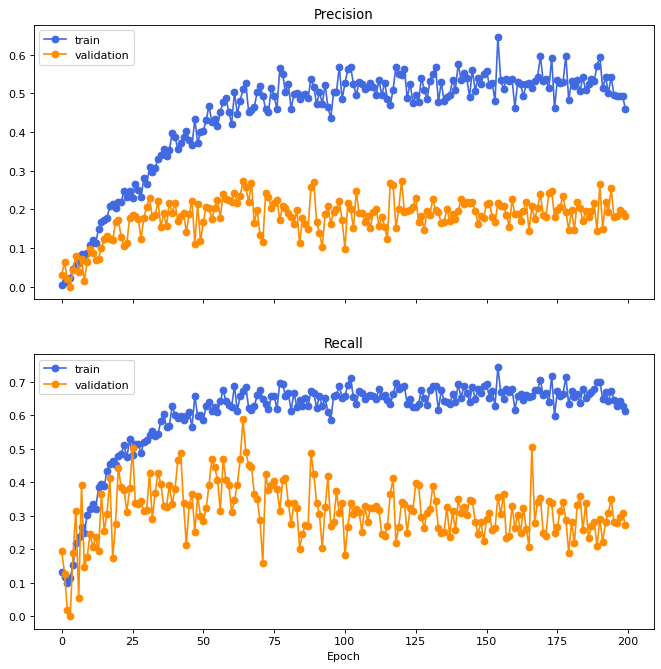

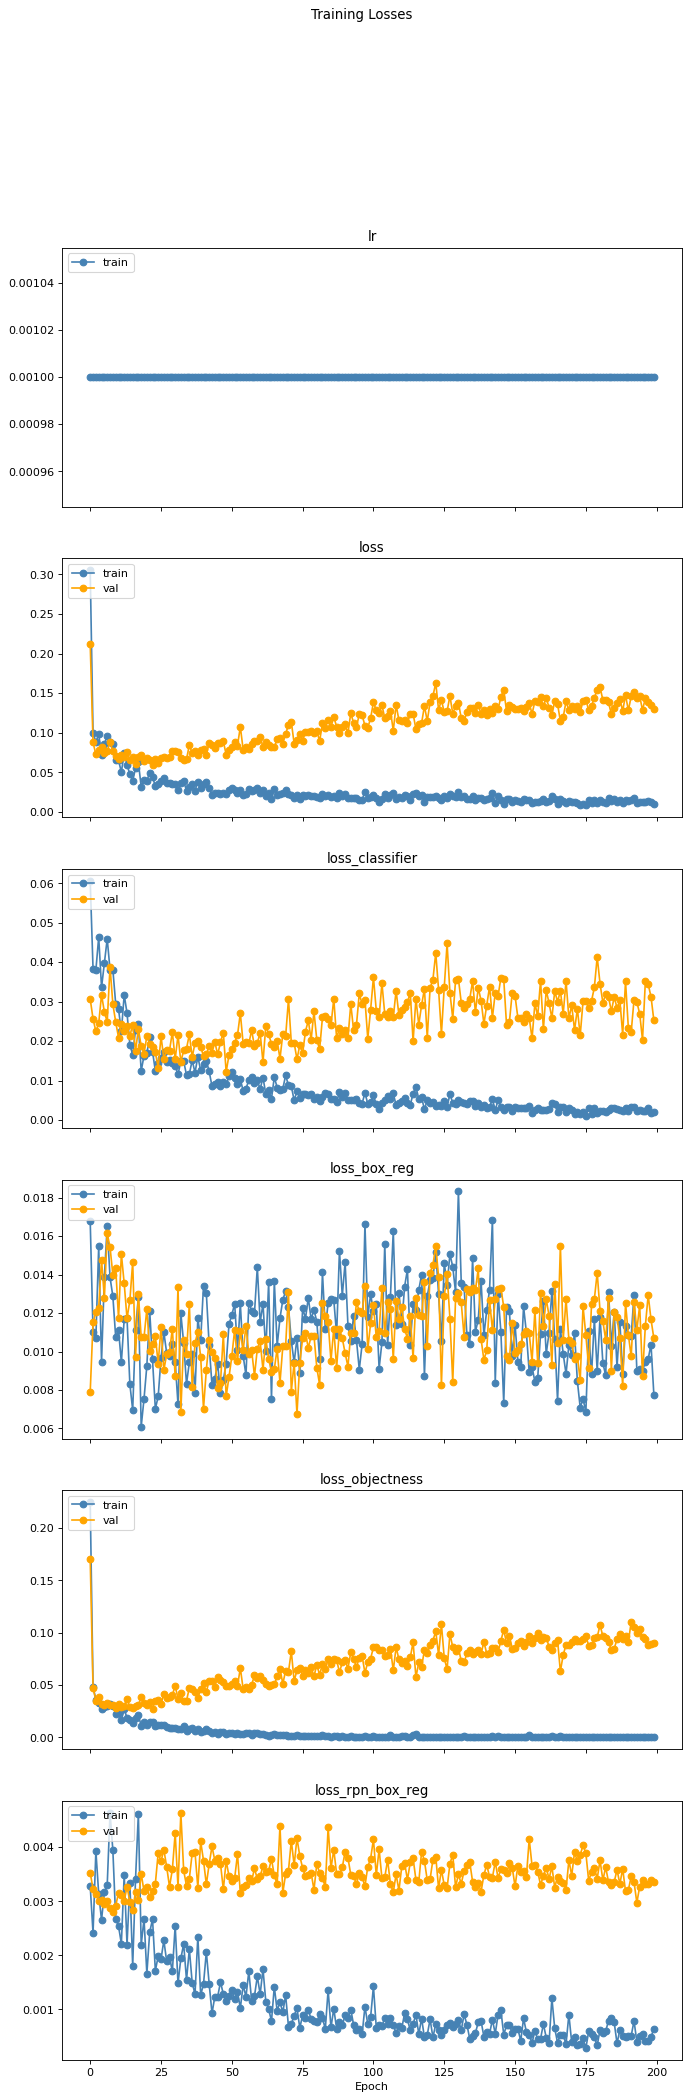

====================| Epoch [200] Done | It has took [403.85] min, Avg time: [121.16] sec/epoch | Estimate time for [200] epochs: [403.85] min | Epoch took [119] sec | ====================
====================| Training Done, start testing! | [200] Epochs Training time: [24231] seconds, Avg time / Epoch: [121.155] seconds====================
====================Best AP validation model has been saved to: [val_ar_0_3410_ap_0_2745_test_ar_0_3106_ap_0_1807_epoch121_WithClincal_05-19-2022 06-41-49_CXR_Clinical]====================
====================Best AR validation model has been saved to: [val_ar_0_5888_ap_0_2725_test_ar_0_4495_ap_0_2114_epoch65_WithClincal_05-19-2022 04-49-22_CXR_Clinical]====================
Evaluation:  [ 0/15]  eta: 0:00:10  loss: 0.3559 (0.3559)  loss_classifier: 0.0212 (0.0212)  loss_box_reg: 0.0225 (0.0225)  loss_objectness: 0.2881 (0.2881)  loss_rpn_box_reg: 0.0240 (0.0240)  model_time: 0.1110 (0.1110)  evaluator_time: 0.0020 (0.0020)  time: 0.7097  data: 0.53

In [7]:
for model_setup in all_model_setups:

    print_f.print_title("Preparing for the training.")

    train_info = TrainingInfo(model_setup)

    model = create_model_from_setup(
        labels_cols,
        model_setup,
        rpn_nms_thresh=0.3,
        box_detections_per_img=10,
        box_nms_thresh=0.2,
        rpn_score_thresh=0.0,
        box_score_thresh=0.05,
    )
    model.to(device)

    ################ Datasets ################
    dataset_params_dict = {
        "XAMI_MIMIC_PATH": XAMI_MIMIC_PATH,
        "with_clinical": model_setup.use_clinical,
        "dataset_mode": model_setup.dataset_mode,
        "bbox_to_mask": model_setup.use_mask,
        "labels_cols": labels_cols,
    }

    detect_eval_dataset, train_dataset, val_dataset, test_dataset = get_datasets(
        dataset_params_dict=dataset_params_dict,
    )

    train_dataloader, val_dataloader, test_dataloader = get_dataloaders(
        train_dataset, val_dataset, test_dataset, batch_size=model_setup.batch_size,
    )

    train_coco, val_coco, test_coco = get_cocos(
        train_dataloader, val_dataloader, test_dataloader
    )

    eval_params_dict = get_eval_params_dict(
        detect_eval_dataset, iou_thrs=iou_thrs, use_iobb=use_iobb,
    )


    # dynamic_loss_weight = None
    dynamic_loss_weight = DynamicWeightedLoss()
    dynamic_loss_weight.to(device)
    print_params_setup(model)


    params = [p for p in model.parameters() if p.requires_grad]
    if dynamic_loss_weight:
        params += [p for p in dynamic_loss_weight.parameters() if p.requires_grad]

    iou_types = get_iou_types(model, model_setup)
    optimizer = get_optimiser(params, model_setup)
    lr_scheduler = get_lr_scheduler(optimizer, model_setup)

    current_time = datetime.now()

    print_f.print_title(
        f"Start training. Preparing Tooke [{ (current_time - train_info.start_t).seconds}] sec"
    )

    train_info.start_t = datetime.now()

    val_loss = None

    ## Start the training from here.
    for e in range(num_epochs):

        print_f.print_title(f"Training model: [{model_setup.name}]")
        print(train_info)

        train_info.epoch = e + 1

        ###### Perform training and show the training result here ######
        model.train()

        train_info.last_train_evaluator, train_loger = xami_train_one_epoch(
            model=model,
            optimizer=optimizer,
            data_loader=train_dataloader,
            device=device,
            epoch=train_info.epoch,
            print_freq=10,
            iou_types=iou_types,
            coco=train_coco,
            score_thres=None,
            evaluate_on_run=True,
            params_dict=eval_params_dict,
            dynamic_loss_weight=dynamic_loss_weight,
        )

        # train_info.train_evaluators.append(train_evaluator)
        train_info.train_data.append(get_data_from_metric_logger(train_loger))
        ################################################################

        ####### Put the model into evaluation mode, start evaluating the current model #######
        model.eval()

        train_info.last_val_evaluator, val_logger = xami_evaluate(
            model=model,
            data_loader=val_dataloader,
            device=device,
            params_dict=eval_params_dict,
            coco=val_coco,
            iou_types=iou_types,
            score_thres=None,
        )

        # train_info.val_evaluators.append(val_evaluator)
        train_info.val_data.append(get_data_from_metric_logger(val_logger))

        train_ap_ar, val_ap_ar = get_ap_ar_for_train_val(
            train_info.last_train_evaluator,
            train_info.last_val_evaluator,
            areaRng="all",
            iouThr=0.5,
            maxDets=10,
        )

        train_info.train_ap_ars.append(train_ap_ar)
        train_info.val_ap_ars.append(val_ap_ar)

        ### update the learning rate

        val_loss = train_info.val_data[-1]["loss"]

        if train_info.epoch > model_setup.warmup_epochs:
            if not lr_scheduler is None:
                if isinstance(lr_scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                    if model_setup.reduceLROnPlateau_full_stop and lr_scheduler.num_bad_epochs >= model_setup.reduceLROnPlateau_patience:
                        print_f.print_title(
                            f"| EarlyStop | Epoch [{train_info.epoch}] Done | It has took [{sec_took/60:.2f}] min, Avg time: [{speed:.2f}] sec/epoch | Estimate time for [{num_epochs}] epochs: [{speed*num_epochs/60:.2f}] min | Epoch took [{epoch_took.seconds}] sec |"
                        )
                        break
                    lr_scheduler.step(val_loss)
                else:
                    lr_scheduler.step()

        ## Clean everything before we show the evaluating result in this stage, so we can inspect the training progress.
        clear_output()

        # if model_setup.record_training_performance:
        plot_train_val_ap_ars(
            train_ap_ars=train_info.train_ap_ars, val_ap_ars=train_info.val_ap_ars,
        )

        plot_losses(train_info.train_data, train_info.val_data)

        previous_time = current_time
        current_time = datetime.now()
        epoch_took = current_time - previous_time

        sec_took = (current_time - train_info.start_t).seconds
        speed = sec_took / train_info.epoch

        print_str = f"| Epoch [{train_info.epoch}] Done | It has took [{sec_took/60:.2f}] min, Avg time: [{speed:.2f}] sec/epoch | Estimate time for [{num_epochs}] epochs: [{speed*num_epochs/60:.2f}] min | Epoch took [{epoch_took.seconds}] sec | "

        if lr_scheduler and hasattr(lr_scheduler, "num_bad_epochs") :
            print_str += f"Patience [{lr_scheduler.num_bad_epochs}] |"

        print_f.print_title(
           print_str
        )

        #######################################################################################
        if model_setup.use_early_stop_model:
            val_ar, val_ap, train_info = check_best(
                device=device,
                eval_params_dict=eval_params_dict,
                train_info=train_info,
                model=model,
                optim=optimizer,
                test_dataloader=test_dataloader,
                test_coco=test_coco,
                iou_types=iou_types,
                score_thres=None,
            )

    val_ar, val_ap = get_ar_ap(train_info.last_val_evaluator)

    train_info = end_train(
        train_info=train_info,
        model=model,
        optim=optimizer,
        eval_params_dict=eval_params_dict,
        last_val_ar=val_ar,        last_val_ap=val_ap,
        test_dataloader=test_dataloader,
        device=device,
        test_coco=test_coco,
        iou_types=iou_types,
        score_thres=None,
    )

    train_infos.append(train_info)


========================================For Training [CXR]========================================
ModelSetup(use_clinical=False, use_custom_model=True, use_early_stop_model=True, name='CXR', best_ar_val_model_path=None, best_ap_val_model_path=None, final_model_path=None, backbone='resnet50', optimiser='sgd', lr=0.001, weight_decay=0, pretrained=True, record_training_performance=True, dataset_mode='unified', image_size=256, backbone_out_channels=16, batch_size=4, warmup_epochs=0, lr_scheduler=None, reduceLROnPlateau_factor=0.1, reduceLROnPlateau_patience=10, reduceLROnPlateau_full_stop=False, multiStepLR_milestones=[100], multiStepLR_gamma=0.1, representation_size=32, mask_hidden_layers=256, using_fpn=True, use_mask=False, clinical_expand_dropout_rate=0, clinical_conv_dropout_rate=0, clinical_input_channels=64, clinical_num_len=9, clinical_conv_channels=256, fuse_conv_channels=32, fuse_dropout_rate=0, box_head_dropout_rate=0, fuse_depth=4, fusion_strategy='add', fusion_residule=False)


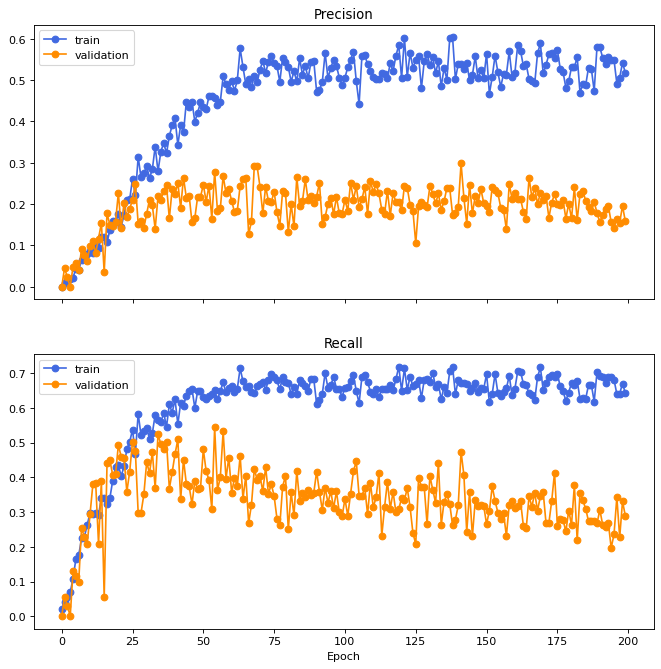

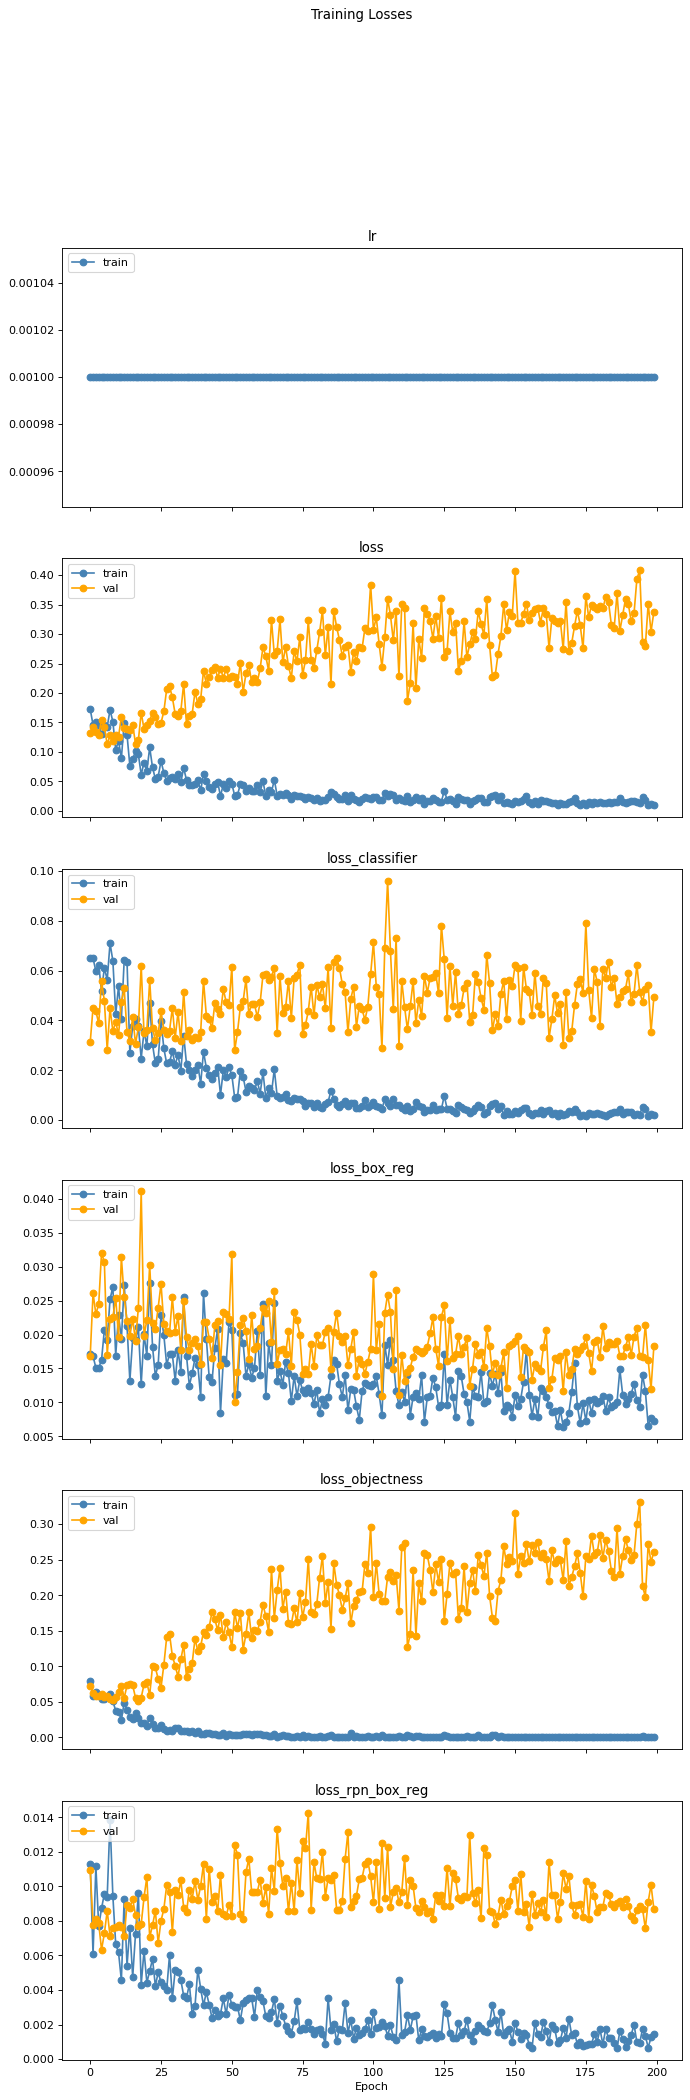

========================================For Training [CXR_Clinical]========================================
ModelSetup(use_clinical=True, use_custom_model=True, use_early_stop_model=True, name='CXR_Clinical', best_ar_val_model_path=None, best_ap_val_model_path=None, final_model_path=None, backbone='resnet50', optimiser='sgd', lr=0.001, weight_decay=0, pretrained=True, record_training_performance=True, dataset_mode='unified', image_size=256, backbone_out_channels=16, batch_size=4, warmup_epochs=0, lr_scheduler=None, reduceLROnPlateau_factor=0.1, reduceLROnPlateau_patience=10, reduceLROnPlateau_full_stop=False, multiStepLR_milestones=[100], multiStepLR_gamma=0.1, representation_size=32, mask_hidden_layers=256, using_fpn=True, use_mask=False, clinical_expand_dropout_rate=0, clinical_conv_dropout_rate=0, clinical_input_channels=64, clinical_num_len=9, clinical_conv_channels=256, fuse_conv_channels=32, fuse_dropout_rate=0, box_head_dropout_rate=0, fuse_depth=4, fusion_strategy='add', fusion

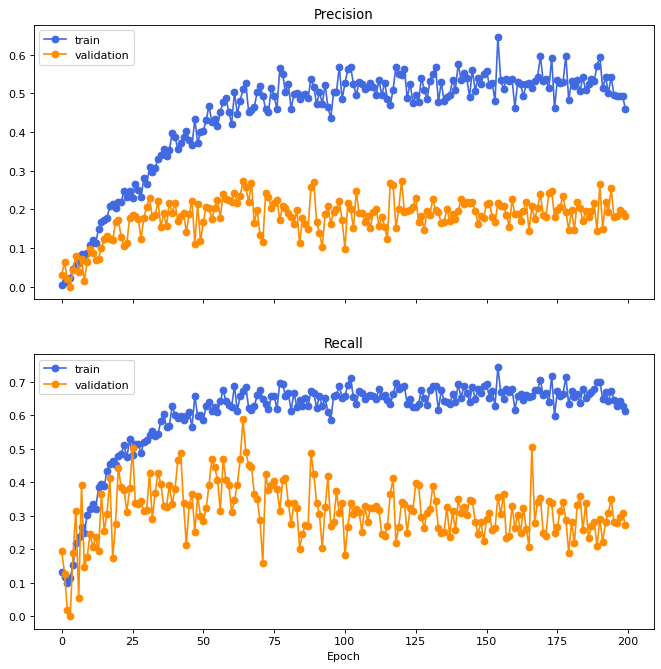

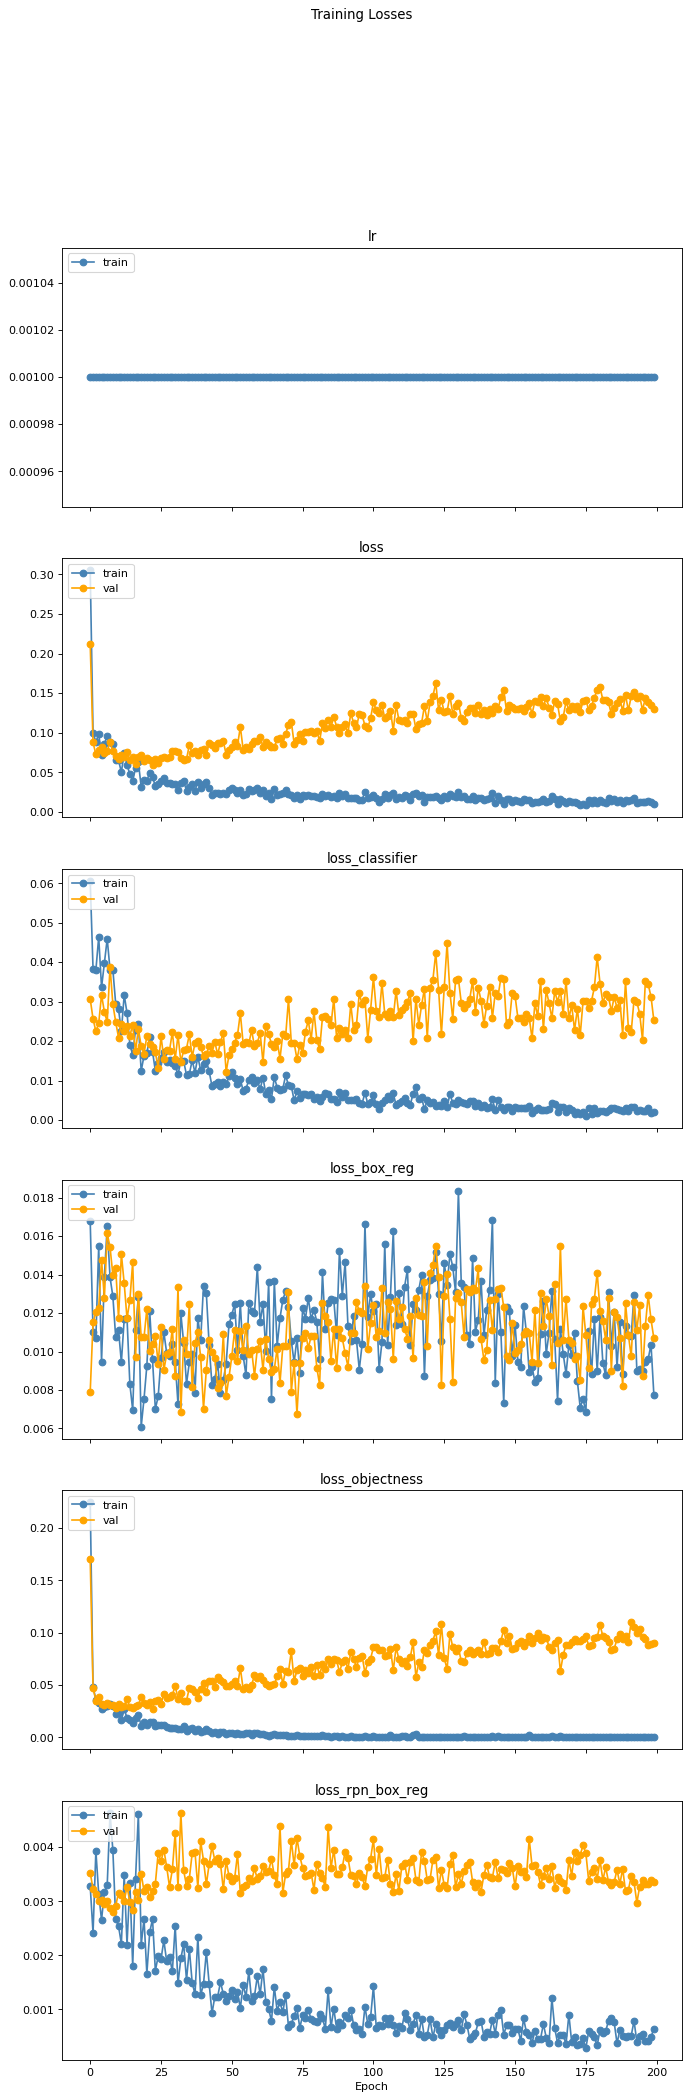

In [8]:
for train_info in train_infos:
    print(train_info)
    model_setup = train_info.model_setup
    model = create_model_from_setup(
        labels_cols,
        model_setup,
        rpn_nms_thresh=0.3,
        box_detections_per_img=10,
        box_nms_thresh=0.2,
        rpn_score_thresh=0.0,
        box_score_thresh=0.05,
    )
    print_params_setup(model)
    plot_train_val_ap_ars(train_info.train_ap_ars, train_info.val_ap_ars)
    plot_losses(train_info.train_data, train_info.val_data)



In [9]:
# for k, v in dynamic_loss_weight.params.items():
#     print(f"{k}:{v}")

In [10]:
# [model]: 4,969,055
# [model.backbone]: 1,009,968
# [model.rpn]: 3,595
# [model.roi_heads]: 3,955,492
# [model.roi_heads.mask_head]: 1,807,360
# [model.roi_heads.box_head]: 1,853,440
# [model.roi_heads.box_head.fc6]: 803,840
# [model.roi_heads.box_head.fc7]: 1,049,600
# [model.roi_heads.box_predictor]: 30,750


In [11]:
# resnet18 -

# mobilenet - 37,301,135
# resnet18 - 30,918,643


In [13]:
# val_ar, val_ap = get_ar_ap(train_info.last_val_evaluator)

# train_info = end_train(
#     train_info=train_info,
#     model=model,
#     optim=optimizer,
#     eval_params_dict=eval_params_dict,
#     last_val_ar=val_ar,
#     last_val_ap=val_ap,
#     test_dataloader=test_dataloader,
#     device=device,   
#     test_coco=test_coco,
#     iou_types=iou_types,
#     score_thres=None,
# )

# print(train_info)

SyntaxError: positional argument follows keyword argument (Temp/ipykernel_22564/3179510494.py, line 6)

========================================For Training [CXR_Clinical]========================================
ModelSetup(use_clinical=True, use_custom_model=True, use_early_stop_model=True, name='CXR_Clinical', best_ar_val_model_path=None, best_ap_val_model_path=None, final_model_path=None, backbone='resnet50', optimiser='sgd', lr=0.001, weight_decay=0, pretrained=True, record_training_performance=True, dataset_mode='unified', image_size=256, backbone_out_channels=16, batch_size=4, warmup_epochs=0, lr_scheduler=None, reduceLROnPlateau_factor=0.1, reduceLROnPlateau_patience=10, reduceLROnPlateau_full_stop=False, multiStepLR_milestones=[100], multiStepLR_gamma=0.1, representation_size=32, mask_hidden_layers=256, using_fpn=True, use_mask=False, clinical_expand_dropout_rate=0, clinical_conv_dropout_rate=0, clinical_input_channels=64, clinical_num_len=9, clinical_conv_channels=256, fuse_conv_channels=32, fuse_dropout_rate=0, box_head_dropout_rate=0.3, fuse_depth=4, fusion_strategy='add', fusi

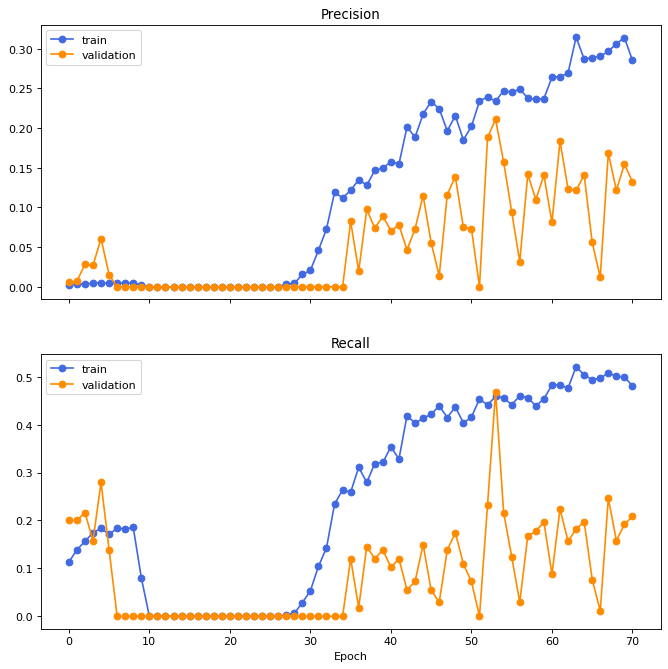

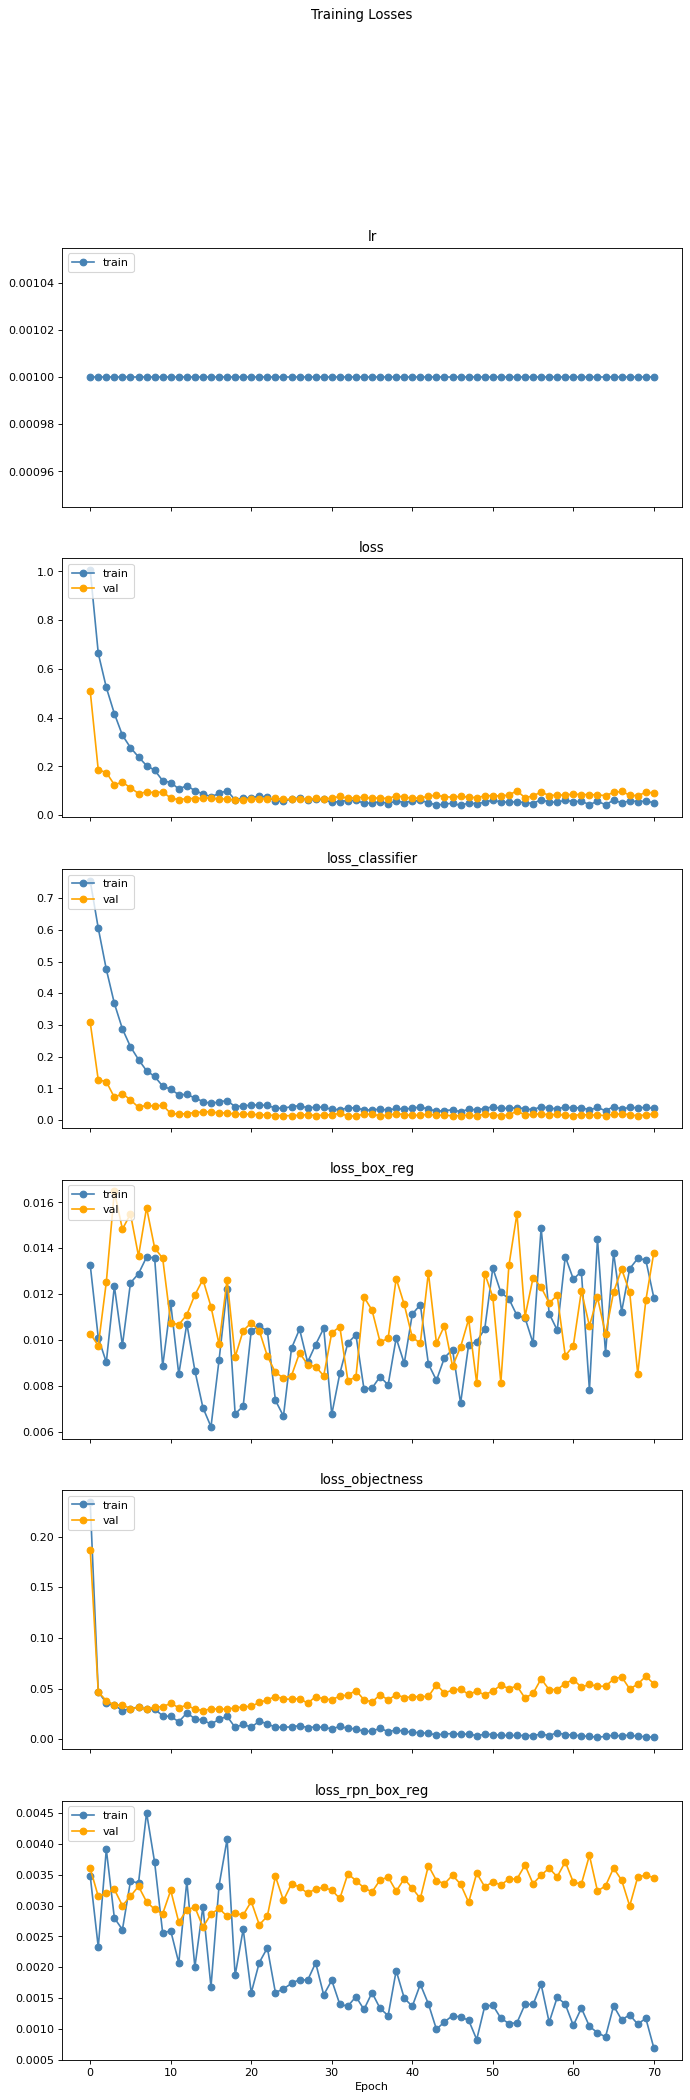

In [ ]:
# print(train_info)
# model_setup = train_info.model_setup
# model = create_model_from_setup(
#     labels_cols,
#     model_setup,
#     rpn_nms_thresh=0.3,
#     box_detections_per_img=10,
#     box_nms_thresh=0.2,
#     rpn_score_thresh=0.0,
#     box_score_thresh=0.05,
# )
# print_params_setup(model)
# plot_train_val_ap_ars(train_info.train_ap_ars, train_info.val_ap_ars)
# plot_losses(train_info.train_data, train_info.val_data)